In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns


In [10]:

df_pos = pd.read_excel('data/ms_volcano_plot/matrice_radiomica.xlsx', sheet_name='POS volcano plot ID', engine='openpyxl')
df_neg = pd.read_excel('data/ms_volcano_plot/matrice_radiomica.xlsx', sheet_name='NEG volcano plot ID', engine='openpyxl')

# merge df_pos and df_neg with name
df_merged = pd.merge(df_pos, df_neg, on='Name', suffixes=('_pos', '_neg'))


# rimuovi il sample id dalle colonne
df_merged = df_merged.loc[:, ~df_merged.columns.str.contains('Name')]




In [11]:
# search all the columns with 4-oxo in their name
oxo_columns = [col for col in df_neg.columns if '4-oxo' in col.lower()]
print("Columns with '4-oxo' in their name:", oxo_columns)

Columns with '4-oxo' in their name: ['2-Hydroxy-4-oxohenicosyl acetate', '2-Hydroxy-4-oxohenicosyl acetate.1', '4-[(2-Isopropyl-5-methylcyclohexyl)oxy]-4-oxobutanoic acid', '4-[(2-Isopropyl-5-methylcyclohexyl)oxy]-4-oxobutanoic acid.1', '4-Oxoproline', '4-Oxoproline.1', '4-Oxoproline.2']


In [12]:
# esplorazione struttura del dataset
print(df_neg.shape)
print(df_neg.info())
print(df_neg.describe())
print(f"Valori unici in Label: {df_neg['Label'].unique()}")

(39, 601)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Columns: 601 entries, Name to β-Muricholic acid.1
dtypes: float64(600), object(1)
memory usage: 183.2+ KB
None
           Label  (-)-Camphanic acid  (-)-Isopiperitenone  (-)-trans-Carveol  \
count  35.000000        3.900000e+01         3.900000e+01       3.900000e+01   
mean    0.685714        3.699649e+06         1.120076e+07       5.565419e+05   
std     0.471008        2.924245e+06         9.324656e+06       4.544048e+05   
min     0.000000        2.000000e-01        -3.400000e-01      -3.200000e-01   
25%     0.000000        1.943593e+06         4.424451e+06       2.191665e+05   
50%     1.000000        2.986907e+06         9.782956e+06       4.474556e+05   
75%     1.000000        4.921924e+06         1.519279e+07       7.513636e+05   
max     1.000000        1.257998e+07         3.437069e+07       1.705922e+06   

       (+)-exo-5-Hydroxycamphor  (+/-)11(12)-EET  \
count              3.900000e+01     

In [17]:
# Rimuovi colonna Label dai metaboliti
X = df_neg.drop('Label', axis=1)
y = df_neg['Label']

# rimuovi "name"
X = X.loc[:, ~X.columns.str.contains('Name')]

# Separa i due gruppi
group_0_data = df_neg[df_neg['Label'] == 0].drop('Label', axis=1)  # Casi gravi
group_1_data = df_neg[df_neg['Label'] == 1].drop('Label', axis=1)  # Controlli

print(f"Gruppo 0 (Casi gravi): {len(group_0_data)} campioni")
print(f"Gruppo 1 (Controlli): {len(group_1_data)} campioni")
print(f"Metaboliti analizzati: {X.shape[1]}")



Gruppo 0 (Casi gravi): 11 campioni
Gruppo 1 (Controlli): 24 campioni
Metaboliti analizzati: 599


In [18]:
# Prepara lista per i risultati
statistical_results = []

# Itera su ogni metabolita
for metabolite in X.columns:
    # Estrai i dati del metabolita dai due gruppi
    values_group0 = group_0_data[metabolite].dropna()
    values_group1 = group_1_data[metabolite].dropna()
    
    # Salta se uno dei gruppi è vuoto
    if len(values_group0) == 0 or len(values_group1) == 0:
        continue
    
    # === MEDIE ===
    mean_0 = values_group0.mean()
    mean_1 = values_group1.mean()
    
    # === FOLD CHANGE (log2) ===
    # log2(media_casi_gravi / media_controlli)
    epsilon = 1e-10  # evita divisione per zero
    log2fc = np.log2((mean_0 + epsilon) / (mean_1 + epsilon))
    
    # === T-TEST (significatività statistica) ===
    t_stat, p_value = ttest_ind(values_group0, values_group1, equal_var=False)
    
    # Evita log(0)
    if p_value == 0:
        p_value = 1e-300
    
    # === SALVA RISULTATI ===
    statistical_results.append({
        'Metabolite': metabolite,
        'Mean_Group0': mean_0,
        'Mean_Group1': mean_1,
        'Log2FC': log2fc,
        'P_Value': p_value,
        'Neg_Log10_P': -np.log10(p_value),
        'T_Statistic': t_stat
    })

# Converti in DataFrame
df_stats = pd.DataFrame(statistical_results)
print(f"\n✓ Analisi statistica completata: {len(df_stats)} metaboliti")
print(df_stats.head(10))


✓ Analisi statistica completata: 599 metaboliti
                                          Metabolite   Mean_Group0  \
0                                 (-)-Camphanic acid  5.059260e+06   
1                                (-)-Isopiperitenone  1.322737e+07   
2                                  (-)-trans-Carveol  6.548658e+05   
3                           (+)-exo-5-Hydroxycamphor  5.885885e+05   
4                                    (+/-)11(12)-EET  1.856358e+06   
5                  (+/-)-6-Hydroxy-3-oxo-alpha-ionol  4.009859e+06   
6                 (+/-)-6-Hydroxy-3-oxo-alpha-ionone  1.532260e+06   
7               (+/-)-6-Hydroxy-3-oxo-alpha-ionone.1  7.285661e+05   
8                                         (±)9-HpODE  3.966640e+07   
9  (1R,2R,6S,7S,8R,10S,11S,12R,16S,17R,18R)-6,7-D...  6.637561e+05   

    Mean_Group1    Log2FC   P_Value  Neg_Log10_P  T_Statistic  
0  3.693102e+06  0.454093  0.307018     0.512836     1.066250  
1  1.213869e+07  0.123913  0.765061     0.116304    

In [19]:
# Definisci soglie
FC_THRESHOLD = 1.0      # Log2 fold change (2x)
P_THRESHOLD = 0.05      # p-value

print(f"\n=== SOGLIE SIGNIFICATIVITÀ ===")
print(f"Fold Change (log2): ±{FC_THRESHOLD}")
print(f"P-value: {P_THRESHOLD}")
print(f"-log10(p): {-np.log10(P_THRESHOLD):.2f}")

# Classifica metaboliti
df_stats['Significance'] = 'Not Significant'

# Up-regulated nei casi gravi
up_mask = (df_stats['Log2FC'] > FC_THRESHOLD) & (df_stats['P_Value'] < P_THRESHOLD)
df_stats.loc[up_mask, 'Significance'] = 'Up in Severe Cases'

# Down-regulated nei casi gravi
down_mask = (df_stats['Log2FC'] < -FC_THRESHOLD) & (df_stats['P_Value'] < P_THRESHOLD)
df_stats.loc[down_mask, 'Significance'] = 'Down in Severe Cases'

# Conteggio
print(f"\n=== RISULTATI CLASSIFICAZIONE ===")
print(df_stats['Significance'].value_counts())
print(f"\nTop metaboliti significativi:")
print(df_stats[df_stats['Significance'] != 'Not Significant'].sort_values('P_Value').head(10))


=== SOGLIE SIGNIFICATIVITÀ ===
Fold Change (log2): ±1.0
P-value: 0.05
-log10(p): 1.30

=== RISULTATI CLASSIFICAZIONE ===
Significance
Not Significant         584
Down in Severe Cases     11
Up in Severe Cases        4
Name: count, dtype: int64

Top metaboliti significativi:
                                            Metabolite   Mean_Group0  \
264                                       4-Oxoproline  1.541828e+07   
480                                          Midodrine  5.687869e+05   
304                                  9-Methyluric acid  8.847370e+05   
589                                           Xanthine  5.890329e+06   
310                                               AMPA  6.056884e+05   
72   [Similar to: Ethyl N?[({4?[(1E)?2?{4?[(1E)?2?(...  9.789318e+05   
251                          4-Amino-4-deoxychorismate  3.267249e+05   
33                                          (R)-Malate  2.905457e+06   
255          4-Formyl-2-methoxyphenyl hydrogen sulfate  6.477281e+05   
89  

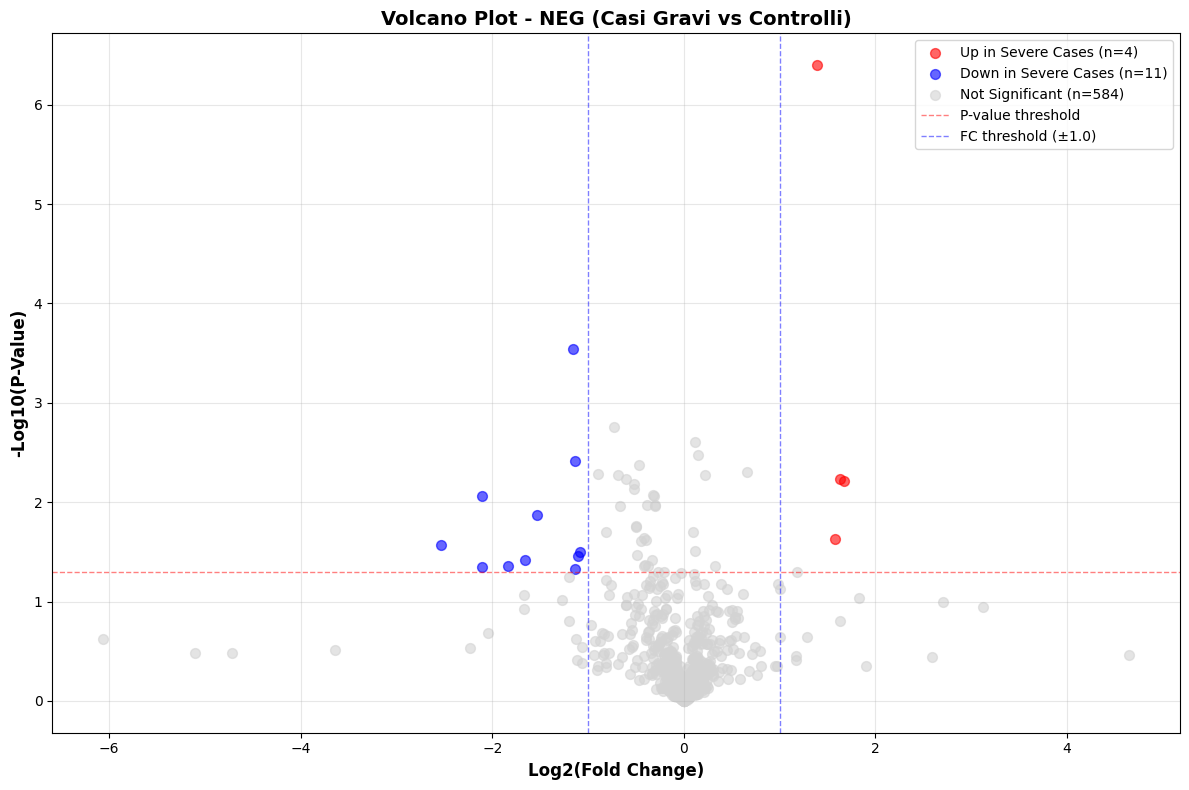

In [20]:
# Crea figura
plt.figure(figsize=(12, 8))

# Definisci colori
colors = {
    'Up in Severe Cases': 'red',
    'Down in Severe Cases': 'blue',
    'Not Significant': 'lightgray'
}

# Plot scatter per ogni categoria
for significance_type, color in colors.items():
    subset = df_stats[df_stats['Significance'] == significance_type]
    if len(subset) > 0:
        plt.scatter(subset['Log2FC'], subset['Neg_Log10_P'], 
                   c=color, alpha=0.6, s=50, 
                   label=f'{significance_type} (n={len(subset)})')

# Aggiungi linee di soglia
plt.axhline(-np.log10(P_THRESHOLD), color='red', linestyle='--', 
           linewidth=1, alpha=0.5, label=f'P-value threshold')
plt.axvline(FC_THRESHOLD, color='blue', linestyle='--', 
           linewidth=1, alpha=0.5)
plt.axvline(-FC_THRESHOLD, color='blue', linestyle='--', 
           linewidth=1, alpha=0.5, label=f'FC threshold (±{FC_THRESHOLD})')

# Etichette e formattazione
plt.xlabel('Log2(Fold Change)', fontsize=12, fontweight='bold')
plt.ylabel('-Log10(P-Value)', fontsize=12, fontweight='bold')
plt.title('Volcano Plot - NEG (Casi Gravi vs Controlli)', fontsize=14, fontweight='bold')
plt.legend(loc='upper right', frameon=True, fancybox=True)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

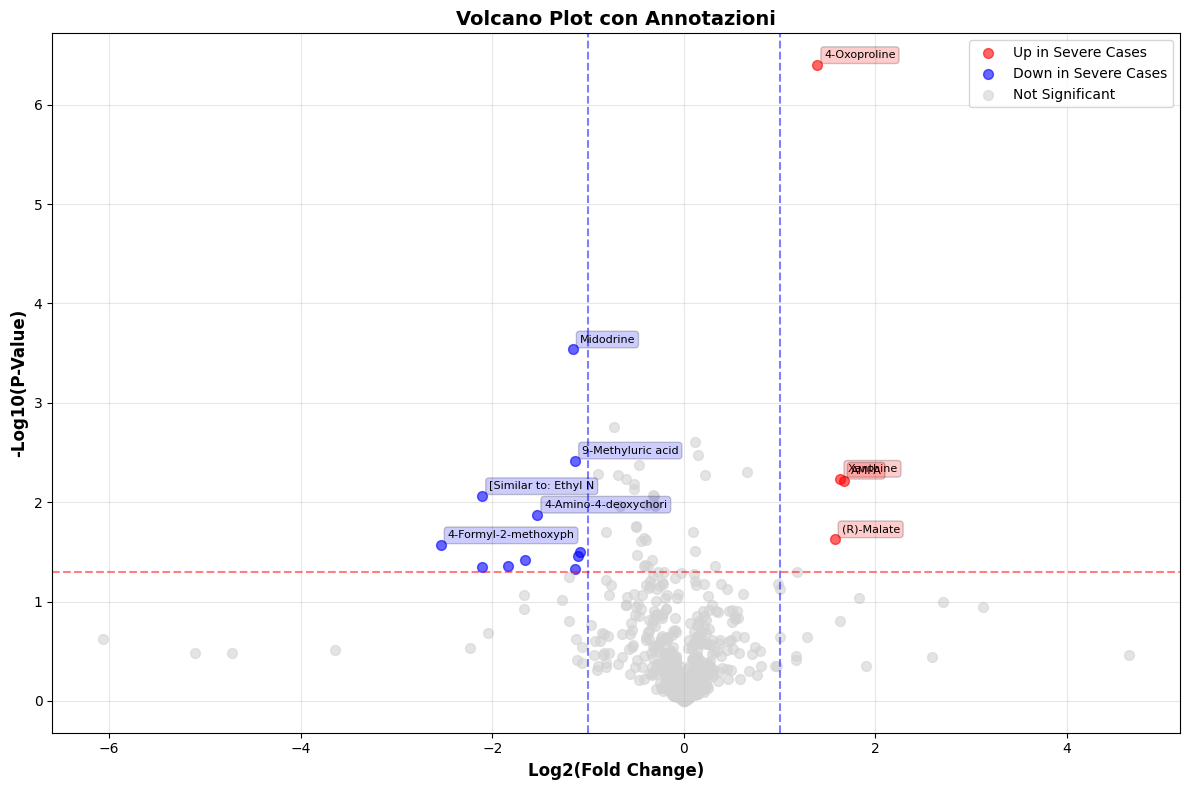

In [ ]:
# Trova top 5 up-regulated
top_up = df_stats[df_stats['Significance'] == 'Up in Severe Cases'].nlargest(1, 'Neg_Log10_P')

# Trova top 5 down-regulated
top_down = df_stats[df_stats['Significance'] == 'Down in Severe Cases'].nlargest(5, 'Neg_Log10_P')

# Crea figura con annotazioni
plt.figure(figsize=(12, 8))

# Plot tutti i punti
for significance_type, color in colors.items():
    subset = df_stats[df_stats['Significance'] == significance_type]
    if len(subset) > 0:
        plt.scatter(subset['Log2FC'], subset['Neg_Log10_P'], 
                   c=color, alpha=0.6, s=50, label=significance_type)

# Aggiungi etichette solamente a 4-oxoproline   
for _, row in top_up.iterrows():
    plt.annotate(row['Metabolite'][:20], 
                 (row['Log2FC'], row['Neg_Log10_P']),
                 textcoords="offset points", xytext=(0,10), ha='center',
                 fontsize=10, fontweight='bold', color='darkred')

plt.axhline(-np.log10(P_THRESHOLD), color='red', linestyle='--', alpha=0.5)
plt.axvline(FC_THRESHOLD, color='blue', linestyle='--', alpha=0.5)
plt.axvline(-FC_THRESHOLD, color='blue', linestyle='--', alpha=0.5)

plt.xlabel('Log2(Fold Change)', fontsize=15, fontweight='bold')
plt.ylabel('-Log10(P-Value)', fontsize=15, fontweight='bold')
plt.title('Volcano Plot', fontsize=15, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('volcano_plot_annotated.png', dpi=300)
plt.tight_layout()
plt.show()

In [23]:
# Salva tutti i risultati
df_stats_sorted = df_stats.sort_values('P_Value')
df_stats_sorted.to_excel('volcano_plot_all_results.xlsx', index=False)

# Salva solo significativi
significant = df_stats[df_stats['Significance'] != 'Not Significant']
significant.to_excel('volcano_plot_significant.xlsx', index=False)

# Salva top 20
df_stats_sorted.head(20).to_excel('volcano_plot_top20.xlsx', index=False)

print("✓ Risultati salvati")
print(f"  - volcano_plot_all_results.xlsx")
print(f"  - volcano_plot_significant.xlsx")
print(f"  - volcano_plot_top20.xlsx")

✓ Risultati salvati
  - volcano_plot_all_results.xlsx
  - volcano_plot_significant.xlsx
  - volcano_plot_top20.xlsx
